# Titanic: Machine Learning from Disaster

## Import necessary packages

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

## Import data

In [98]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## Exploratory Data Analysis

In [99]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [100]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Missing Values

In [101]:
# The numbers of missing value in Cabin are too large in both set, so we drop the column
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [102]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [103]:
df_train = df_train.drop(columns = ['Cabin'])
df_test = df_test.drop(columns = ['Cabin'])

In [104]:
# The number of missing value in df_train['Embarked'] is just 2, and in df_test['Embarked'] is 0.
df_train=df_train.drop(df_train[df_train['Embarked'].isnull()==True].index, axis = 0)

In [105]:
# Fill the missing value of Age by the mean value.
df_train['Age'].fillna(df_train['Age'].mean(), inplace = True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace = True)

In [106]:
# Fill the missing value of Fare in df_test by the mean value.
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace = True)

In [107]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [108]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Feature Selection

In [110]:
df_train['Ticket'].duplicated().sum()

209

In [111]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [112]:
# Find out any correlation between Ticket and ant other column
df_train.loc[df_train['Ticket'].str.contains('A/5')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.000000,0,0,A/5. 2151,8.0500,S
132,133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.000000,1,0,A/5. 3337,14.5000,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.500000,0,2,A/5. 851,14.5000,S
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.000000,0,0,A/5 3540,8.0500,S
212,213,0,3,"Perkin, Mr. John Henry",male,22.000000,0,0,A/5 21174,7.2500,S
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.500000,0,0,A/5 21173,7.2500,S
253,254,0,3,"Lobb, Mr. William Arthur",male,30.000000,1,0,A/5. 3336,16.1000,S
283,284,1,3,"Dorking, Mr. Edward Arthur",male,19.000000,0,0,A/5. 10482,8.0500,S
304,305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,29.642093,0,0,A/5 2466,8.0500,S


In [113]:
df_train.loc[df_train['Ticket'].str.contains('STON')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,S
115,116,0,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,STON/O 2. 3101294,7.925,S
142,143,1,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.850,S
173,174,0,3,"Sivola, Mr. Antti Wilhelm",male,21.0,0,0,STON/O 2. 3101280,7.925,S
216,217,1,3,"Honkanen, Miss. Eliina",female,27.0,0,0,STON/O2. 3101283,7.925,S
243,244,0,3,"Maenpaa, Mr. Matti Alexanteri",male,22.0,0,0,STON/O 2. 3101275,7.125,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,S
400,401,1,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.925,S
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.850,S
414,415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.925,S


In [114]:
df_train.loc[df_train['Ticket'].str.contains('PC')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.000000,0,0,PC 17601,27.7208,C
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,29.642093,1,0,PC 17569,146.5208,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000000,1,0,PC 17572,76.7292,C
64,65,0,1,"Stewart, Mr. Albert A",male,29.642093,0,0,PC 17605,27.7208,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000000,0,0,PC 17754,34.6542,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.000000,0,1,PC 17759,63.3583,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.000000,0,1,PC 17558,247.5208,C
139,140,0,1,"Giglio, Mr. Victor",male,24.000000,0,0,PC 17593,79.2000,C


From the aggregate data we can find that the prefix of ticket numbers are highly correlated with the Pclass. At the same time, there are also duplicated numbers in it. So I drop the column.

In [115]:
df_train = df_train.drop(columns = ['Ticket'])
df_test = df_test.drop(columns = ['Ticket'])

In [116]:
# For the name column, the only useful information is the prefix for everyone, which is also revealed in the Age and Sex columns
# So we drop this column
df_train = df_train.drop(columns = ['Name'])
df_test = df_test.drop(columns = ['Name'])

In [117]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [118]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


### Analysis and Visualization

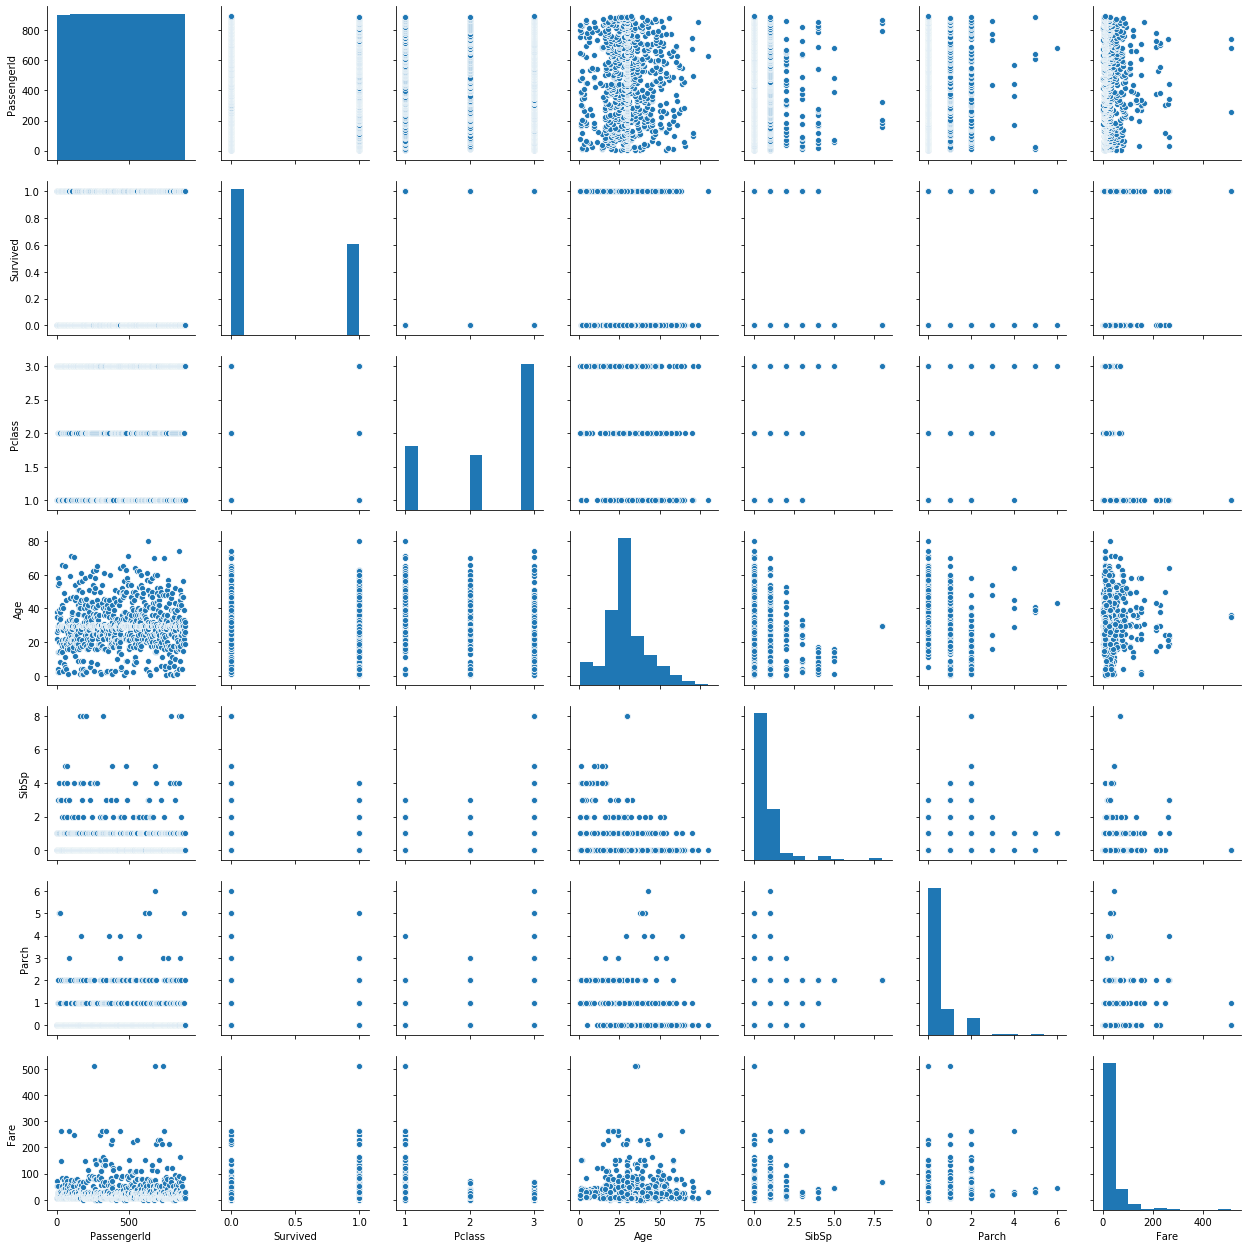

In [119]:
fig_pair = sns.pairplot(df_train)
fig_pair

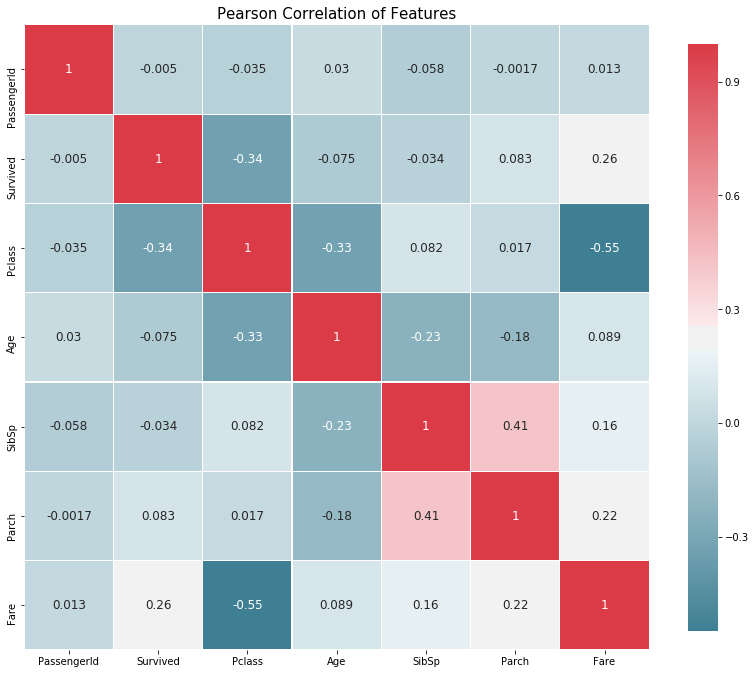

In [120]:
def correlation_heatmap(df):
    fig , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    fig = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_train)

In [157]:
# Distribution function
def barplot(column, axis_x, axis_y):
    sns.barplot(x = column, y = 'Survived',  data=df_train, ax = axis[axis_x,axis_y])
    axis[axis_x,axis_y].set_title('{} - Survival Distribution'.format(column))

In [158]:
df_train['Age_bin'] = pd.cut(df_train['Age'],8)
df_train['Fare_bin'] = pd.cut(df_train['Fare'],10)

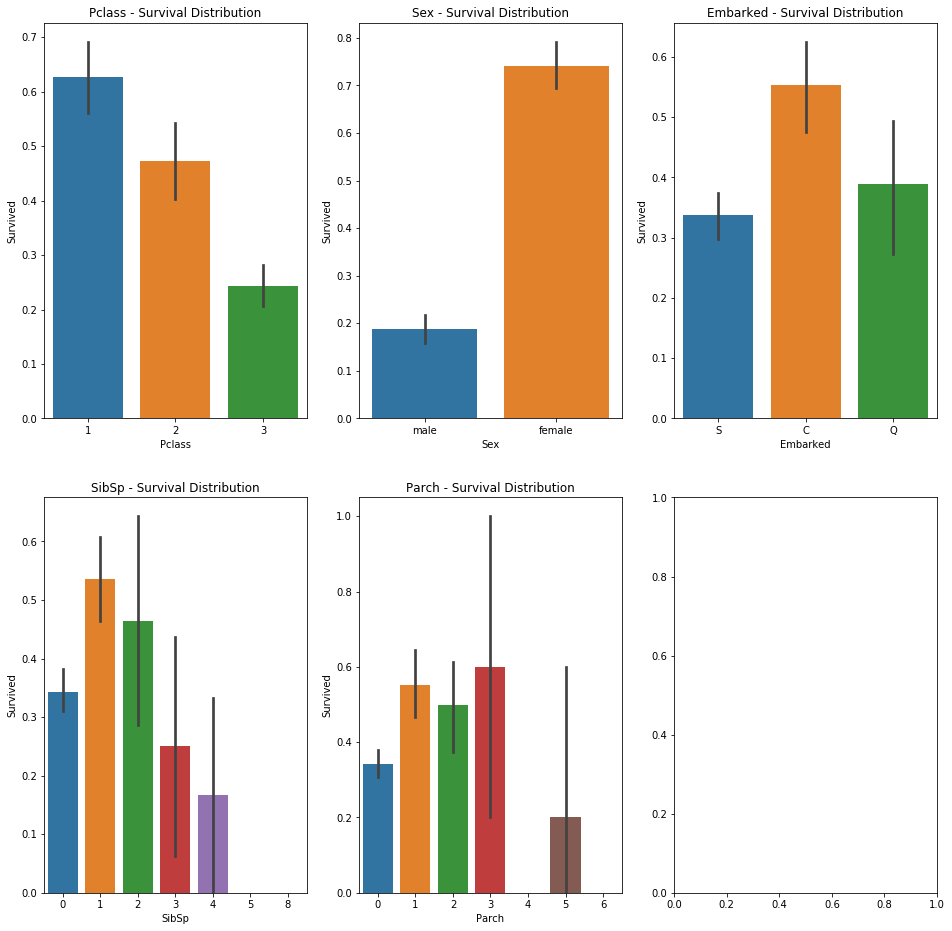

In [159]:
fig, axis = plt.subplots(2,3,figsize=(16,16))
barplot('Pclass', 0, 0)
barplot('Sex', 0, 1)
barplot('Embarked', 0, 2)
barplot('SibSp', 1, 0)
barplot('Parch', 1, 1)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

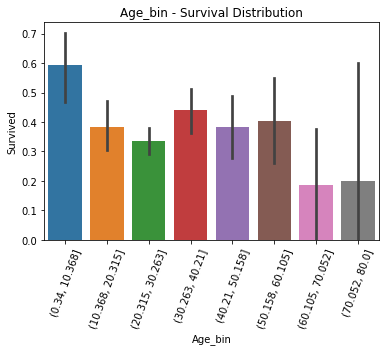

In [160]:
sns.barplot(x = 'Age_bin', y = 'Survived',  data=df_train).set_title('Age_bin - Survival Distribution')
plt.xticks(rotation = 70)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

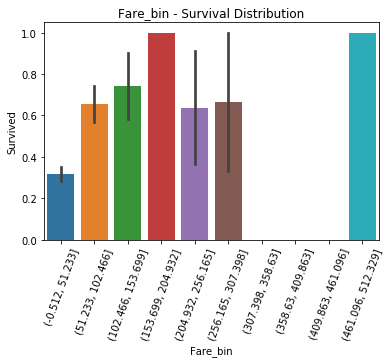

In [161]:
sns.barplot(x = 'Fare_bin', y = 'Survived',  data=df_train).set_title('Fare_bin - Survival Distribution')
plt.xticks(rotation = 70)

In [135]:
df_train[df_train['Fare']>100]['Survived'].mean()

0.7358490566037735

In [162]:
df_train[df_train['Fare']<50]['Survived'].mean()

0.31917808219178084

In [164]:
df_train = df_train.drop(columns = ['Age_bin','Fare_bin'])

# Prediction

### Convert categrical columns to int type for Regression

In [165]:
# Convert Embarked column to int type
embarked = []
for port in list(df_train['Embarked']):
    if port == 'S':
        embarked.append(1)
    elif port == 'C':
        embarked.append(2)
    else:
        embarked.append(3)

df_train = df_train.drop(columns = ['Embarked'])
df_train['Embarked'] = embarked

In [166]:
embarked = []
for port in list(df_test['Embarked']):
    if port == 'S':
        embarked.append(1)
    elif port == 'C':
        embarked.append(2)
    else:
        embarked.append(3)

df_test = df_test.drop(columns = ['Embarked'])
df_test['Embarked'] = embarked

In [167]:
# Convert Sex column to int type
gender = []
for sex in list(df_train['Sex']):
    if sex == 'male':
        gender.append(0)
    else:
        gender.append(1)
        
df_train = df_train.drop(columns = ['Sex'])
df_train['Sex'] = gender

In [168]:
gender = []
for sex in list(df_test['Sex']):
    if sex == 'male':
        gender.append(0)
    else:
        gender.append(1)
        
df_test = df_test.drop(columns = ['Sex'])
df_test['Sex'] = gender

### Model Construction And Prediction

In [169]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Sex'],
      dtype='object')

In [170]:
features=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Sex' ]

X=df_train[features]
y=df_train['Survived']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True)

In [172]:
def grid(model, params):
    return GridSearchCV(model, params, cv=10, iid = False).fit(X_train, y_train)  

In [173]:
params1={'n_estimators':[50, 100], 'learning_rate':[0.5,1]}
AdaBoost_grid = grid(model = AdaBoostClassifier(random_state=36), params = params1)

In [174]:
params2={'n_estimators':[10, 50]}
Bagging_grid = grid(model = BaggingClassifier(random_state=36), params = params2)

In [175]:
params3={'n_estimators':[100, 200], 'learning_rate':[0.5,1]}
GradientBoosting_grid = grid(model = GradientBoostingClassifier(random_state=36), params = params3)

In [176]:
params4={'n_estimators': [50, 100], 'min_samples_split': [2, 4]}
RandomForest_grid = grid(model = RandomForestClassifier(random_state=36), params = params4)

In [177]:
params5={'max_iter':[1000, 2000, 5000], 'cv':[3, 5]}
Logistic_grid = grid(model = LogisticRegressionCV(random_state=36), params = params5)

In [178]:
params6={'n_neighbors':[5,10], 'p':[1,2]}
KNeighbors_grid = grid(model = KNeighborsClassifier(), params = params6)

In [179]:
params7={'probability':[True, False], 'decision_function_shape': ['ovo', 'ovr'], 'gamma':['auto' , 'scale']}
SVC_grid = grid(model = SVC(random_state=36), params = params7) 

In [180]:
params8={'max_depth':range(2,10)}
DecisionTree_grid = grid(model = DecisionTreeClassifier(random_state=36), params = params8)  

In [181]:
best_models = [
    AdaBoost_grid,
    Bagging_grid,
    GradientBoosting_grid,
    RandomForest_grid,
    Logistic_grid,
    RidgeClassifierCV(),
    KNeighbors_grid,
    SVC_grid,
    DecisionTree_grid
]
names = [
    'AdaBoost',
    'Bagging',
    'GradientBoosting',
    'RandomForest',
    'Logistic',
    'Ridge',
    'KNeighbors',
    'SVC',
    'DecisionTree'
]                        

In [182]:
def get_cv_score(model, X, y) :
    CV_scores=cross_val_score(model, X, y, cv = 10)
    return np.round(np.mean(CV_scores), 3)

In [183]:
scores = []
for model in best_models:
    scores.append(get_cv_score(model = model, X = X, y = y))

In [184]:
scores

[0.807, 0.822, 0.817, 0.816, 0.8, 0.79, 0.722, 0.695, 0.8]

In [204]:
df_Scores = pd.DataFrame({'Name':names, 'Score': scores})
df_Scores.sort_values(by = 'Score',ascending = False)

,Name,Score
1,Bagging,0.822
2,GradientBoosting,0.817
3,RandomForest,0.816
0,AdaBoost,0.807
4,Logistic,0.800
8,DecisionTree,0.800
5,Ridge,0.790
6,KNeighbors,0.722
7,SVC,0.695


### Predicting

In [186]:
test = df_test[features]

In [195]:
Bagging_grid.fit(X, y)
pred = Bagging_grid.predict(test)

In [196]:
df_test['Survived'] = pred

In [197]:
df_pred = df_test[['PassengerId', 'Survived']]

In [198]:
df_pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [199]:
df_pred.to_csv('prediction.csv', index = False)

In [200]:
df = pd.read_csv('prediction.csv')

In [201]:
df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [202]:
len(df)

418